In [308]:
import random
from time import perf_counter
from copy import deepcopy
from typing import Literal
from itertools import cycle

import pandas as pd
import numpy as np
from scipy.special import logsumexp

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report,
                             roc_curve, auc, confusion_matrix, RocCurveDisplay)

from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier, LogisticRegression

In [30]:
eps = 1e-9

SEED = 18092025
random.seed(SEED)
np.random.seed(SEED)

[Датасет](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

In [31]:
try:
    df = pd.read_csv('../datasets/data.csv', delimiter=';')
except Exception:
    print('No such file')

In [32]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

pd.set_option('display.expand_frame_repr', False)


# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_colwidth')
# pd.reset_option('display.width')
# pd.reset_option('display.expand_frame_repr')

---

## EDA

In [33]:
def display_nans(df):
    nans_per_col = [(col, df[col].isna().sum(), df[col].isna().sum() / df.shape[0] * 100) for col in df.columns]
    dtype = [('col_name', 'U20'), ('nans', int), ('nans_perc', float)]
    nans_per_col = np.array(nans_per_col, dtype=dtype)
    nans_per_col = nans_per_col[nans_per_col['nans'] > 0]
    nans_per_col = np.sort(nans_per_col, order='nans')

    if nans_per_col.shape[0] == 0:
        print('No nans in the dataset')
        return

    df_show = pd.DataFrame(nans_per_col[::-1])
    display(df_show.style.background_gradient(cmap='Blues'))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    y_pos = np.arange(len(nans_per_col))
    
    ax.barh(y_pos, nans_per_col['nans_perc'], alpha=0.8, edgecolor='black', linewidth=1) 
    ax.set_yticks(y_pos, labels=nans_per_col['col_name'])
    ax.set_xlabel('Nans, %', fontsize=14)
    ax.set_title('Nans rate for each column', fontsize=16)
    ax.set_xlim(0, min(np.max(df_show['nans_perc']) + 5.0, 100.0))
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.grid(axis='x', linestyle='--', linewidth=0.5)
    
    plt.show()

In [34]:
display(df.head())
print('Dataset shape: ', df.shape)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Dataset shape:  (4424, 37)


In [35]:
def col_names_transform(col_name: str) -> str:
    res_name = col_name.strip().replace("\t", "").replace(' ', '_').lower()
    return res_name

In [36]:
df.columns = map(col_names_transform, df.columns.values)
df.columns

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime/evening_attendance', 'previous_qualification',
       'previous_qualification_(grade)', 'nacionality',
       'mother's_qualification', 'father's_qualification',
       'mother's_occupation', 'father's_occupation', 'admission_grade',
       'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_(credited)',
       'curricular_units_1st_sem_(enrolled)',
       'curricular_units_1st_sem_(evaluations)',
       'curricular_units_1st_sem_(approved)',
       'curricular_units_1st_sem_(grade)',
       'curricular_units_1st_sem_(without_evaluations)',
       'curricular_units_2nd_sem_(credited)',
       'curricular_units_2nd_sem_(enrolled)',
       'curricular_units_2nd_sem_(evaluations)',
       'curricular_units_2nd_sem_(approved)',
       'curricular_units_2nd_s

In [37]:
df.describe()

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,previous_qualification_(grade),nacionality,mother's_qualification,father's_qualification,mother's_occupation,father's_occupation,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_(credited),curricular_units_1st_sem_(enrolled),curricular_units_1st_sem_(evaluations),curricular_units_1st_sem_(approved),curricular_units_1st_sem_(grade),curricular_units_1st_sem_(without_evaluations),curricular_units_2nd_sem_(credited),curricular_units_2nd_sem_(enrolled),curricular_units_2nd_sem_(evaluations),curricular_units_2nd_sem_(approved),curricular_units_2nd_sem_(grade),curricular_units_2nd_sem_(without_evaluations),unemployment_rate,inflation_rate,gdp
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,10.960895,11.032324,126.978119,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,23.265145,0.024864,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,26.418253,25.263040,14.482001,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,7.587816,0.155729,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,4.000000,4.000000,117.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,5.000000,7.000000,126.100000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,134.800000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,194.000000,195.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [38]:
# TODO: добавить другие стат. показатели 

In [39]:
display_nans(df)

No nans in the dataset


In [40]:
df.dtypes

marital_status                                      int64
application_mode                                    int64
application_order                                   int64
course                                              int64
daytime/evening_attendance                          int64
previous_qualification                              int64
previous_qualification_(grade)                    float64
nacionality                                         int64
mother's_qualification                              int64
father's_qualification                              int64
mother's_occupation                                 int64
father's_occupation                                 int64
admission_grade                                   float64
displaced                                           int64
educational_special_needs                           int64
debtor                                              int64
tuition_fees_up_to_date                             int64
gender        

In [41]:
df['target'].value_counts(normalize=True).to_frame().T

target,Graduate,Dropout,Enrolled
proportion,0.499322,0.321203,0.179476


---

## Подготовка данных

In [42]:
X, y = df.drop(columns=['target']), df['target']
X.shape, y.shape

((4424, 36), (4424,))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True, stratify=y)
# X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, shuffle=True, stratify=y_train)
y_train.shape, y_test.shape

((3539,), (885,))

In [44]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
# X_val_scaled   = std_scaler.transform(X_val)
X_test_scaled  = std_scaler.transform(X_test)
X_train_scaled[0, :5]

array([-0.29563934, -0.0374792 , -0.55645717,  0.31315804,  0.34938119])

In [45]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train.values)
# y_val_enc   = label_encoder.transform(y_val.values)
y_test_enc  = label_encoder.transform(y_test.values)
y_train[:5].values, y_train_enc[:5], label_encoder.classes_

(array(['Graduate', 'Dropout', 'Dropout', 'Enrolled', 'Dropout'],
       dtype=object),
 array([2, 0, 0, 1, 0]),
 array(['Dropout', 'Enrolled', 'Graduate'], dtype=object))

---

## Модель линейной классификации

In [338]:
class LogRegNumpy():

    def __init__(
        self,
        # --- base params
        initial_weights:   list[list[float]] = None, # (n_features, n_classes)
        initial_bias:      list[float] = None,       # (1, n_classes)
        init_strategy:     Literal['normal', 'corr', 'multistart'] = 'normal',
        # --- fit params
        total_steps:    int = 1000,
        learning_rate:  float = 1e-3,
        gd_algo:        Literal['gd', 'sgd', 'minibatch'] = 'sgd',
        batch_size:     int | None = None, # None = full dataset
        momentum:       float = 0.0,
        l2:             float = 0.0,
        optim_step:     bool = False,
        # early stopping
        early_stopping: bool = False,
        tolerance:      float = 1e-3,
        n_startup_rounds:  int = 10,
        early_stop_rounds: int = 5,
        validation_fraction: float = 0.1, # (0.0, 1.0)
        # recurrent loss function estimation
        rec_mode:                Literal['off','mean','ema'] = 'off',
        ema_lambda:              float = 0.1,
        # sampling strategy
        sampling_mode:           Literal['uniform','by_margin'] = 'uniform',
        shuffle:                 bool = True,
        sampling_tau:            float = 0.2, # TODO: check what it means actually
        sampling_min_prob:       float = 0.01,
        refresh_rate:            int = 100, # how often to update samples probability distribution
        # --- logs
        steps_per_epoch:         int | None = 100, # how often to update logs, to evaluate intermediate loss, etc.
        verbose:                 bool = False,
        # --- misc
        use_best_weights:        bool = False,
        return_weights_history:  bool = False,
        random_seed: int = SEED,
        eps: float = 1e-9
    ):
        # --- base params init
        self.weights = (np.array(initial_weights) if initial_weights is not None 
                        else np.array([]))
        self.bias = (np.array(initial_bias) if initial_bias is not None 
                     else np.array([]))
        self.init_strategy = init_strategy
        # --- fit params init
        self.total_steps = total_steps
        self.learning_rate = learning_rate
        self.gd_algo = gd_algo
        self.batch_size = batch_size
        self.momentum = momentum
        self.l2 = l2
        self.optim_step = optim_step
        # early stopping
        self.early_stopping = early_stopping
        self.tolerance = tolerance
        self.n_startup_rounds = n_startup_rounds
        self.early_stop_rounds = early_stop_rounds
        self.validation_fraction = validation_fraction
        # recurrent loss function estimation
        self.rec_mode = rec_mode
        self.ema_lambda = ema_lambda
        # sampling strategy
        self.sampling_mode = sampling_mode
        self.shuffle = shuffle
        self.sampling_tau = sampling_tau
        self.sampling_min_prob = sampling_min_prob
        self.refresh_rate = refresh_rate
        # --- logs
        self.steps_per_epoch = steps_per_epoch
        self.verbose = verbose
        # --- misc init
        self.use_best_weights = use_best_weights
        self.return_weights_history = return_weights_history
        self.random_seed = random_seed
        self.eps = eps

        self.rng_ = np.random.default_rng(seed=random_seed)

        # для рекуррентной оценки
        self.rec_value = None
        self.rec_count = 0
        self.rec_history = []

    
    def fit(
        self,
        X, y,
    ) -> None | list[list[float]]:

        input_check = lambda data, dtype: (
            np.array(data, dtype=dtype).squeeze()
            if not isinstance(data, np.ndarray)
            else deepcopy(data).astype(dtype, copy=False)
        )
        X, y = input_check(X, np.float32), input_check(y, np.int32)
        if X.ndim == 1:
            X = X[np.newaxis, :]

        if self.early_stopping:
            X, X_val, y, y_val = train_test_split(
                X, y, test_size=self.validation_fraction, 
                random_state=self.random_seed, shuffle=self.shuffle, stratify=y
            )

        N = X.shape[0]

        # TODO: try python switch-case
        if self.gd_algo == 'gd':
            self.batch_size = N
        elif self.gd_algo == 'sgd':
            self.batch_size = 1

        if self.steps_per_epoch is None:
            self.steps_per_epoch = (N + self.batch_size - 1) // self.batch_size

        # --- init
        # Initialization is done on the whole dataset (sorry for this, but I'm tired)
        self._init_weights(X, y, n_starts=5, search_steps=50, lr=self.learning_rate)
        if self.return_weights_history:
            weights_values = dict(weights=[self.weights.copy()], bias=[self.bias.copy()])
        Vdw = np.zeros_like(self.weights)
        Vdb = np.zeros_like(self.bias)
        self._rec_reset()
        self.loss_values = ([], []) if self.early_stopping else [] # Loss is cleared each fit call
        rng = self.rng_
        learning_rate = self.learning_rate
            
        def uniform_next_batch_stateful():
            perm = rng.permutation(N) if self.shuffle else np.arange(N, dtype=np.int64)
            ptr = 0

            def get_batch():
                nonlocal perm, ptr
                if ptr >= N:
                    perm = rng.permutation(N) if self.shuffle else np.arange(N, dtype=np.int64)
                    ptr = 0

                remaining = N - ptr
                take = self.batch_size if self.batch_size <= remaining else remaining

                idx = perm[ptr:ptr + take]
                ptr += take
                return idx

            return get_batch

        margin_probs = lambda: self._margin_sampling_probs(
            X, y, use_abs=True, tau=self.sampling_tau, min_prob=self.sampling_min_prob
        )

        # ---- training loop (one unified path)
        step = 0
        block_loss_sum = 0.0
        block_count = 0

        if self.sampling_mode == 'uniform':
            next_uniform_batch = uniform_next_batch_stateful()
        elif self.sampling_mode == 'by_margin':
            probs = margin_probs()
            next_uniform_batch = None
        else:
            raise ValueError("sampling_mode must be 'uniform' or 'by_margin'")

        # --- init validation score
        # Train
        loss = self._get_loss(X, y)
        if self.early_stopping:
            self.loss_values[0].append(loss)
        else:
            self.loss_values.append(loss)
        # recurrent quality update (train loss)
        train_rec_val = self._rec_update(loss)
        self.rec_history.append(train_rec_val)
        # Validation
        if self.early_stopping:
            loss = self._get_loss(X_val, y_val)
            self.loss_values[1].append(loss)

        # for early stopping similarly to sklearn
        no_improvement_counter = 0   
        best_loss = loss
        best_step = 0

        while step < self.total_steps:
            if self.sampling_mode == 'uniform':
                batch_idx = next_uniform_batch()
            else:  # by_margin
                if step % self.refresh_rate == 0:
                    probs = margin_probs()
                batch_idx = rng.choice(N, size=self.batch_size, replace=True, p=probs)

            xi = X[batch_idx, :]
            yi = y[batch_idx]

            # forward / loss
            logits = self.forward(xi)
            loss   = self._loss_fn_opt(yi, logits, reduction=None)

            # Self-Normalized Importance Sampling Loss
            if self.sampling_mode == 'by_margin':
                pi = probs[batch_idx]
                sample_weights = 1.0 / np.clip(pi, 1e-12, None)
                loss = (loss * sample_weights).sum() / sample_weights.sum()
            else:
                sample_weights = None
                loss = loss.mean()
            
            block_loss_sum += loss
            block_count    += 1

            # recurrent quality update (train loss)
            train_rec_val = self._rec_update(loss)
            self.rec_history.append(train_rec_val)

            # gradients
            w_grad, b_grad = self._gradient(xi, yi, logits)
            # L2 - regularization
            if self.l2 > 0.0:
                w_grad += self.l2 * self.weights

            # momentum (EMA style)
            Vdw = self.momentum * Vdw - (1.0 - self.momentum) * w_grad
            Vdb = self.momentum * Vdb - (1.0 - self.momentum) * b_grad
            
            if self.optim_step:
                learning_rate = self._line_search_backtracking(
                    xi, yi, w_grad, b_grad, Vdw, Vdb
                )

            # update
            self.weights += learning_rate * Vdw
            self.bias    += learning_rate * Vdb

            step += 1

            # Logging once per “epoch-sized” number of steps.
            # Early stopping criteria check
            if block_count >= self.steps_per_epoch:
                mean_block_loss = block_loss_sum / block_count

                if self.early_stopping:
                    self.loss_values[0].append(mean_block_loss)
                    loss = self._get_loss(X_val, y_val)
                    self.loss_values[1].append(loss)
                else:
                    self.loss_values.append(mean_block_loss)
                    # Workaround, loss value should represent global tendency in loss change.
                    # Current loss is value for a single opt. step.
                    loss = mean_block_loss

                # # recurrent quality update - for better plots maybe should log once per block, not every opt. step
                # rec_val = self._rec_update(mean_block_loss, mode=rec_mode, ema_lambda=ema_lambda)
                # self.rec_history.append(rec_val)

                # Early stopping on monitored series (smoothed if rec_mode != 'off').
                # Done on training set, if early_stopping = False, else on validation set
                # Recalculating loss on validation each opt. step is too costly actually
                if (self.tolerance is not None) and (step > self.n_startup_rounds + 1):
                    if loss > best_loss - self.tolerance:
                        no_improvement_counter += 1
                        if no_improvement_counter >= self.early_stop_rounds:
                            if self.verbose:
                                print(f"Last loss : {loss}\t Best loss: {best_loss} on step {best_step}({best_step // self.steps_per_epoch})\t")
                                print(f"Early stopping at step {step}({step // self.steps_per_epoch})")
                            break
                    else:
                        best_loss = loss
                        no_improvement_counter = 0
                        best_step = step
                        if self.use_best_weights:
                            best_weights = self.weights.copy()
                            best_bias = self.bias.copy()


                if self.return_weights_history:
                    weights_values['weights'].append(self.weights.copy())
                    weights_values['bias'].append(self.bias.copy())
                if self.verbose:
                    print(f"step {step:6d} ({step // self.steps_per_epoch}) | block_loss={mean_block_loss:.6f} | batch_size={self.batch_size} | mode={self.sampling_mode}")

                block_loss_sum = 0.0
                block_count = 0

        if self.use_best_weights:
            self.weights = best_weights
            self.bias = best_bias

        if self.return_weights_history:
            return np.array(weights_values)
        
        return
        
    def _get_loss(self, X, y):
        logits = self.forward(X)
        loss = self._loss_fn_opt(y, logits, reduction='mean')
        return loss
        
    def _line_search_backtracking(
        self,
        X, y, 
        grad_w: np.ndarray, grad_b: np.ndarray, 
        dir_w:  np.ndarray, dir_b:  np.ndarray,
        step: float = 1.0, 
        alpha: float = 1e-4, 
        beta: float = 0.5, 
        tol: float = 1e-8,
        default_lr: float = 1e-9,
        eps: float = 1e-12
    ):
        logits_0 = self.forward(X)
        loss_0 = self._loss_fn_opt(y, logits_0, reduction='mean')
        if self.l2 > 0.0:
            loss_0 += self.l2 * np.sum(np.pow(self.weights, 2)) * 0.5
        
        W0 = self.weights
        b0 = self.bias

        # directional derivatives
        dw = (grad_w * dir_w).sum()
        db = (grad_b * dir_b).sum()
        dd = dw + db
        
        if self.l2 > 0.0:
            dd += self.l2 * (W0 * dir_w).sum()

        if dd >= eps:
            if np.allclose(dir_w, -grad_w) and np.allclose(dir_b, -grad_b):
                return 0.0
            # switching to regular gradient descent
            np.copyto(dst=dir_w, src=-grad_w); np.copyto(dst=dir_b, src=-grad_b)
            dd = (grad_w * dir_w).sum() + (grad_b * dir_b).sum()
            if self.l2 > 0.0:
                dd += self.l2 * (W0 * dir_w).sum()
            if dd >= eps:
                return 0.0

        t = step

        # TODO: добавить оптимизации через раскрытие logits_t и l2_norm и предварительного подсчета неизменных членов
        while t > tol:
            Wt = W0 + t * dir_w
            bt = b0 + t * dir_b
            logits_t = np.matmul(X, Wt) + bt
            loss_t = self._loss_fn_opt(y, logits_t, reduction='mean')
            if self.l2 > 0.0:
                loss_t += self.l2 * np.sum(np.pow(Wt, 2)) * 0.5

            if loss_t <= loss_0 + alpha * t * dd:
                return t
            
            t *= beta

        return default_lr


    def predict(self, features: list[list[float]]):
        X = (np.array(features).squeeze() if not isinstance(features, np.ndarray) 
             else deepcopy(features).astype(np.float32, copy=False))
        if X.ndim == 1:
            X = X[np.newaxis, :]
        logits = self.forward(X) # (n_samples, n_classes)
        probs  = self._softmax(logits) # не обязательно
        return np.argmax(probs, axis=1)

    def predict_proba(self, features: list[list[float]]):
        X = (np.array(features).squeeze() if not isinstance(features, np.ndarray) 
             else deepcopy(features).astype(np.float32, copy=False))
        if X.ndim == 1:
            X = X[np.newaxis, :]
        logits = self.forward(X) # (n_samples, n_classes)
        probs  = self._softmax(logits) # не обязательно
        return probs
    
    def _create_onehot_target(self, y: np.array):
        ohe_enc = OneHotEncoder(categories=[np.unique(y)], sparse_output=False)
        y_enc = ohe_enc.fit_transform(y.reshape(-1, 1))
        return y_enc # output -> (n_samples, n_classes)
    
    def _init_weights(
        self, X: np.ndarray, y: np.ndarray,
        n_starts: int = 5, search_steps: int = 50, lr: float = 1e-2,
    ):
        N, d = X.shape
        K = np.max(y) + 1

        if self.init_strategy == 'normal':
            if self.weights.size == 0:
                self.weights = self.rng_.standard_normal((d, K), dtype=np.float32)
            if self.bias.size == 0:
                self.bias = self.rng_.standard_normal((1, K), dtype=np.float32)
            return

        if self.init_strategy == 'corr':
            # by default this strategy assumes that input data already was standardized
            if self.weights.size != 0 and self.bias.size != 0:
                return
            # евклидова норма
            # denom = np.sum(X * X, axis=0)       # shape (d,)
            denom = np.float64(N)

            W = np.zeros((d, K), dtype=np.float64)
            b = np.zeros((1, K), dtype=np.float64)

            for k in range(K):
                t = (y == k).astype(np.float64) # 1 for class k, else 0
                # weights: elementwise division by per-feature squared norm
                # With centered X, X^T t == X^T (t - mean(t)), so no need to center t explicitly.
                numer = X.T @ t                           # shape (d,)
                W[:, k] = numer / denom

                # intercept: with centered features, LS gives b_k = mean(t^{(k)})
                b[0, k] = t.mean()

            if self.weights.size == 0:
                self.weights = W.astype(np.float32, copy=False)
            if self.bias.size == 0:
                self.bias = b.astype(np.float32, copy=False)
            return
        
        if self.init_strategy == 'multistart':
            best_loss = np.inf
            best_W, best_b = None, None

            for _ in range(n_starts):
                W = self.rng_.standard_normal((d, K), dtype=np.float32)
                b = self.rng_.standard_normal((1, K), dtype=np.float32)
                
                # short warmup
                w, b, loss = self._warmup(X, y, W, b, steps=search_steps, lr=lr)
                if loss < best_loss:
                    best_loss = loss
                    best_W, best_b = w, b

                self.weights = best_W
                self.bias    = best_b
            return
        
        raise ValueError("init_strategy must be 'normal' or 'corr'")
    
    # Warmup is performed on the whole input dataset, not on batches
    def _warmup(self, X, y, W, b, steps=50, lr=1e-2):
        W = W.copy(); b = b.copy()
        for _ in range(steps):
            logits = np.matmul(X, W) + b
            loss   = self._loss_fn_opt(y, logits, reduction='mean')
            w_grad, b_grad = self._gradient(X, y, logits)
            W -= lr * w_grad
            b -= lr * b_grad
        return W, b, float(loss)
    
        
    def _softmax(self, X: np.array) -> np.array:
        Z = X - np.max(X, axis=1, keepdims=True)
        numerator = np.exp(Z)
        denominator = np.sum(numerator, axis=1, keepdims=True)
        softmax_probs = numerator / denominator
        return softmax_probs # -> (n_samples, n_classes)
    
    def forward(self, X):
        # (n_samples, n_features) * (n_features, n_classes)
        logits = np.matmul(X, self.weights) + self.bias # -> (n_samples, n_classes)
        return logits
    
    # def loss_fn_expanded(self, X, y_true):
    #     # (n_samples, n_features) * (n_features, n_classes) + (n_samples, 1) * (1, n_classes) = (n_samples, n_classes)
    #     logits = np.matmul(X, self.weights) + np.matmul(np.ones((X.shape[0], 1)), self.bias)
    #     exp_logits = np.exp(logits)
    #     logits_sum = np.sum(exp_logits, axis=1) # -> (n_samples, 1)
    #     # (n_samples, n_classes) * (n_samples, n_classes)
    #     true_class_logits = logits[np.arange(X.shape[0]), y_true]
    #     return np.mean(np.log(logits_sum) - true_class_logits)

    # def loss_fn(self, y_true, logits):
    #     log_probs = np.log(self.softmax(logits)) # -> (n_samples, classes)
    #     # y_true_ohe = self.create_onehot_target(y_true) # -> (n_samples, classes)
    #     # likelihood = (log_probs * y_true_ohe).sum(axis=1).mean()
    #     likelihood = (log_probs[np.arange(log_probs.shape[0]), y_true]).mean()
    #     return -likelihood
    
    def _loss_fn_opt(self, y_true, logits, reduction=None):
        lse = logsumexp(logits, axis=1, keepdims=True)
        nll = lse - logits
        loss = nll[np.arange(nll.shape[0]), y_true]
        if reduction == 'mean':
            loss = loss.mean()
        return loss
    
    def _rec_reset(self):
        self.rec_value = None
        self.rec_count = 0
        self.rec_history = []

    def _rec_update(self, xi):
        # Smoothing is applied only to train loss history.
        # Validation loss shouldn't be smoothed.
        # One possible explanation for this - validation loss is always calculated on the whole val set,
        # so there is no more reason to apply smoothing to it. 
        if self.rec_mode == "off":
            return xi

        if self.rec_value is None:
            # инициализация последовательности
            self.rec_value = xi
            self.rec_count = 1
            return self.rec_value

        if self.rec_mode == "mean":
            # running mean: Q_m = (1/m)*xi_m + (1 - 1/m)*Q_{m-1}
            self.rec_count += 1
            m = self.rec_count
            self.rec_value = (1.0 / m) * xi + (1.0 - 1.0 / m) * self.rec_value
            return self.rec_value

        if self.rec_mode == "ema":
            # EMA: Q_m = λ xi_m + (1 - λ) Q_{m-1}
            self.rec_value = self.ema_lambda * xi + (1.0 - self.ema_lambda) * self.rec_value
            return self.rec_value

        return xi

    def _gradient(self, X, y_true, logits):
        y_prob = self._softmax(logits)
        y_prob[np.arange(y_prob.shape[0]), y_true] -= 1
        y_prob /= y_prob.shape[0]
        w_grad = np.matmul(X.T, y_prob)
        b_grad = y_prob.sum(axis=0, keepdims=True)
        return w_grad, b_grad
    
    # Only for multiclass, no separate implementation for binary case
    # TODO: make binary case margin estimation
    def calc_margins(self, X, y_true):
        logits = self.forward(X)
        true_logits = logits[np.arange(X.shape[0]), y_true]
        logits[np.arange(logits.shape[0]), y_true] = -np.inf
        false_logits = logits.max(axis=1)
        margins = true_logits - false_logits
        return margins

    # TODO: сделать сэмплер с разной логикой выбора сложных случаев
    # 1) -abs(margins) - для любых (правильных или нет) случаев с малой долей уверенности
    # 2) -margins вместо -abs(margins) - для точно неправильно классифицированных случаев
    def _margin_sampling_probs(
        self, X, y, use_abs: bool = True, tau: float = 0.2, min_prob: float = 0.01
    ):
        margins = self.calc_margins(X, y)

        diff = -np.abs(margins) if use_abs else -margins
        scores = diff / max(tau, 1e-8)
        probs = self._softmax(scores.reshape(1, -1)).squeeze()

        floor = min_prob / X.shape[0]
        probs = (1.0 - min_prob) * probs + floor

        return probs

In [271]:
logreg = LogRegNumpy(
    # --- base params
    init_strategy = 'normal',
    # --- fit args
    total_steps = X_train_scaled.shape[0]*100, 
    learning_rate = 1e-2,
    gd_algo = 'sgd',
    batch_size = 1,
    momentum = 0.0,
    l2 = 0.01, 
    optim_step = False,
    # early stopping
    early_stopping = True,
    tolerance = 1e-4,
    n_startup_rounds = 0,
    early_stop_rounds = 5,
    validation_fraction = 0.1,
    # рекуррентная оценка функции потерь
    rec_mode = 'ema', 
    ema_lambda = 0.01,
    # стратегия сэмплирования
    sampling_mode = 'uniform',
    shuffle = True, 
    sampling_tau = 0.5,
    sampling_min_prob = 0.01, 
    refresh_rate = 200,
    # --- logs
    steps_per_epoch = 500,
    verbose=True,
    # --- misc
    use_best_weights = False,
    return_weights_history = False,
    random_seed = SEED
)

In [272]:
logreg.fit(X_train_scaled, y_train_enc)

step    500 (1) | block_loss=3.445631 | batch_size=1 | mode=uniform
step   1000 (2) | block_loss=1.619331 | batch_size=1 | mode=uniform
step   1500 (3) | block_loss=1.265814 | batch_size=1 | mode=uniform
step   2000 (4) | block_loss=0.907089 | batch_size=1 | mode=uniform
step   2500 (5) | block_loss=0.811109 | batch_size=1 | mode=uniform
step   3000 (6) | block_loss=0.727240 | batch_size=1 | mode=uniform
step   3500 (7) | block_loss=0.656123 | batch_size=1 | mode=uniform
step   4000 (8) | block_loss=0.656556 | batch_size=1 | mode=uniform
step   4500 (9) | block_loss=0.602336 | batch_size=1 | mode=uniform
step   5000 (10) | block_loss=0.599033 | batch_size=1 | mode=uniform
step   5500 (11) | block_loss=0.604705 | batch_size=1 | mode=uniform
step   6000 (12) | block_loss=0.672297 | batch_size=1 | mode=uniform
step   6500 (13) | block_loss=0.656332 | batch_size=1 | mode=uniform
step   7000 (14) | block_loss=0.647038 | batch_size=1 | mode=uniform
step   7500 (15) | block_loss=0.619901 | ba

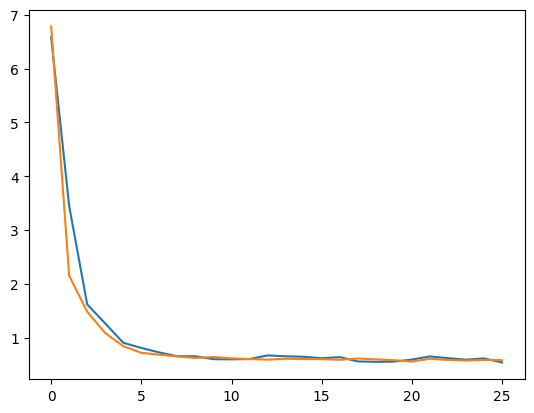

In [273]:
plt.plot(logreg.loss_values[0])
plt.plot(logreg.loss_values[1])
plt.show()

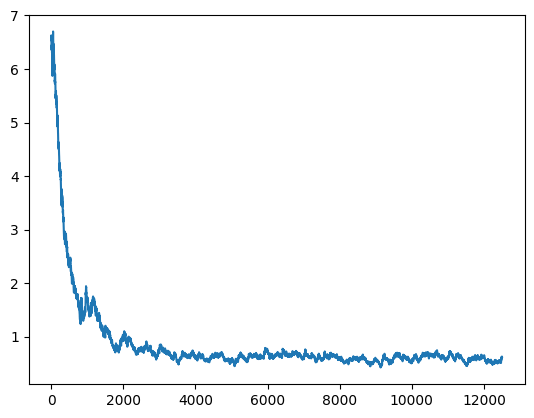

In [274]:
plt.plot(logreg.rec_history)
plt.show()

In [349]:
def viz_margins(margins, eps=1.0):
    sorted_idx = np.argsort(margins)
    sorted_margins = margins[sorted_idx]
    
    line_kwargs      = {'lw': 2}
    pos_fill_kwargs  = {'alpha': 0.25, 'color': 'tab:green'}
    neg_fill_kwargs  = {'alpha': 0.25, 'color': 'tab:red'}
    zero_fill_kwargs = {'alpha': 0.25, 'color': 'gold'}

    # masks
    if eps > 0.0:
        mask_zero = np.abs(sorted_margins) <= eps
        mask_pos  = sorted_margins >  eps
        mask_neg  = sorted_margins < -eps
    else:
        mask_zero = np.zeros_like(sorted_margins, dtype=bool)
        mask_pos  = sorted_margins > 0
        mask_neg  = sorted_margins < 0

    plt.figure(figsize=(12, 7))
    # line
    plot_idx = np.arange(sorted_margins.shape[0])
    plt.plot(plot_idx, sorted_margins, **line_kwargs)
    plt.axhline(0.0, color='black', lw=1, alpha=0.7)

    if np.any(mask_neg):
        plt.fill_between(plot_idx, sorted_margins, 0.0, where=mask_neg, interpolate=True, **neg_fill_kwargs)
    if np.any(mask_zero):
        plt.fill_between(plot_idx, sorted_margins, 0.0, where=mask_zero, interpolate=True, **zero_fill_kwargs)
    if np.any(mask_pos):
        plt.fill_between(plot_idx, sorted_margins, 0.0, where=mask_pos, interpolate=True, **pos_fill_kwargs)

    plt.xlabel("sample index (sorted)")
    plt.ylabel("margin")
    plt.title("Margin curve with signed areas")
    plt.tight_layout()
    plt.show()

    return

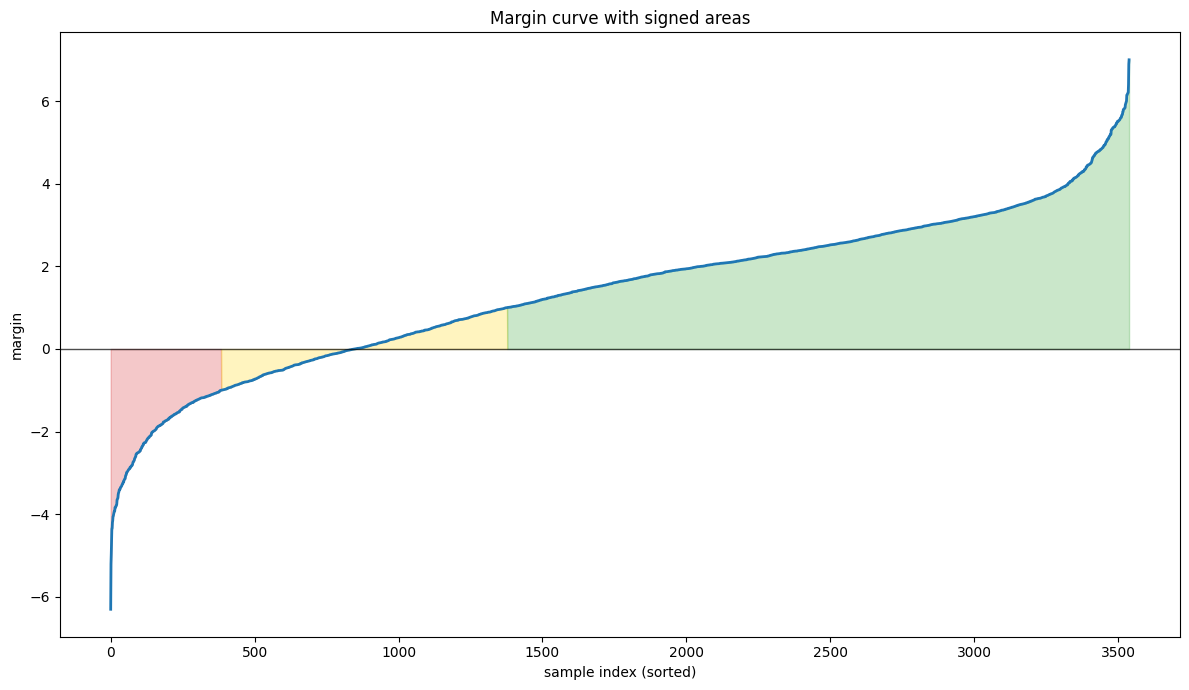

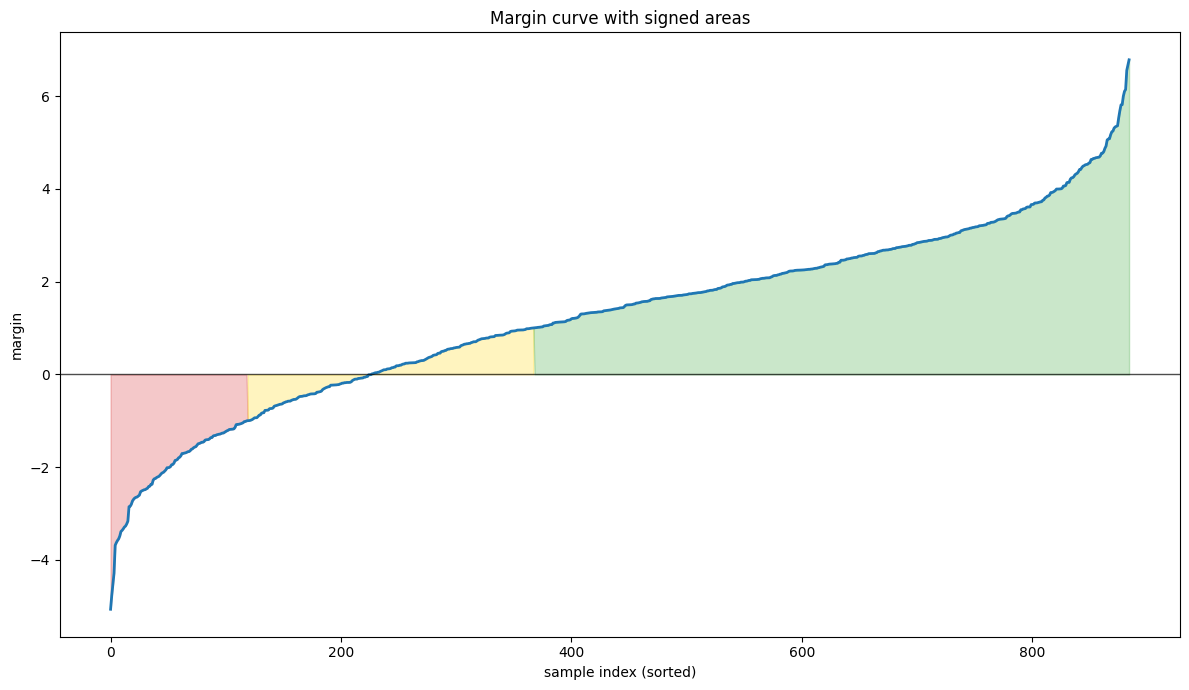

In [350]:
margins_train = logreg.calc_margins(X_train_scaled, y_train_enc)
margins_test  = logreg.calc_margins(X_test_scaled,  y_test_enc)

viz_margins(margins_train)
viz_margins(margins_test)

In [276]:
preds_train = logreg.predict(X_train_scaled)
# preds_val   = logreg.predict(X_val_scaled)
preds_test  = logreg.predict(X_test_scaled)

In [277]:
print(f'Train accuracy: {(preds_train == y_train_enc).mean()*100.:.4f}')
# print(f'Validation accuracy: {(preds_val == y_val_enc).mean()*100.:.4f}')
print(f'Test accuracy: {(preds_test == y_test_enc).mean()*100.:.4f}')

Train accuracy: 76.0667
Test accuracy: 74.3503


In [335]:
# ---- your existing helpers kept as-is ----
def _ensure_class_names(y_true, y_pred, class_names):
    if class_names is None:
        classes = sorted(list(set(np.asarray(y_true).tolist()) | set(np.asarray(y_pred).tolist())))
        class_names = [str(c) for c in classes]
        labels = classes
    else:
        labels = class_names if not np.issubdtype(np.asarray(y_true).dtype, np.integer) else list(range(len(class_names)))
    return class_names, labels

def plot_multiclass_confusion_matrix(
    y_true, y_pred, class_names=None, normalize=True, cmap="Blues", figsize=(10,8), annot=True, title=None
):
    class_names, labels = _ensure_class_names(y_true, y_pred, class_names)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        with np.errstate(invalid="ignore", divide="ignore"):
            cm = cm / cm.sum(axis=1, keepdims=True)
        fmt, cbar_label = ".2f", "Proportion"
    else:
        fmt, cbar_label = "d", "Count"

    plt.figure(figsize=figsize)
    ax = sns.heatmap(cm, annot=annot, fmt=fmt, cmap=cmap,
                     xticklabels=class_names, yticklabels=class_names,
                     linewidths=.5, linecolor="white", cbar_kws={"label": cbar_label})
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title or ("Confusion Matrix (row-normalized)" if normalize else "Confusion Matrix"))
    plt.tight_layout()
    plt.show()

def per_class_tp_fp_fn_tn_table(y_true, y_pred, class_names=None):
    class_names, labels = _ensure_class_names(y_true, y_pred, class_names)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    return pd.DataFrame({"TP": tp, "FP": fp, "FN": fn, "TN": tn}, index=class_names)

def plot_tp_fp_fn_tn_table(y_true, y_pred, class_names=None, cmap="YlGnBu", figsize=(6,1.2), title=None):
    df = per_class_tp_fp_fn_tn_table(y_true, y_pred, class_names)
    plt.figure(figsize=(figsize[0], figsize[1] * len(df)))
    ax = sns.heatmap(df, annot=True, fmt="d", cmap=cmap, cbar=False,
                     linewidths=.5, linecolor="white")
    ax.set_xlabel("Metric")
    ax.set_ylabel("Class")
    ax.set_title(title or "Per-class TP / FP / FN / TN")
    plt.tight_layout()
    plt.show()

# ----------------- model adapters you already had -----------------
def _try_fit(model, Xtr, ytr, fit_args, Xval=None, yval=None):
    try:
        return model.fit(Xtr, ytr, **(fit_args or {}))
    except TypeError:
        val_set = (Xval, yval) if (Xval is not None and yval is not None) else (None, None)
        return model.fit((Xtr, ytr), val_set, **(fit_args or {}))

def _proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)
    df = model.decision_function(X)
    if df.ndim == 1:
        df = np.c_[-df, df]
    e = np.exp(df - df.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

# ----------------- New pretty table utilities (alignment-fixed, ASCII fallback) -----------------

def _print_cv_tables(cv_df: pd.DataFrame, *, title="Cross-Validation", ascii_borders=True):
    cv_df = cv_df.copy()
    cv_df.index.name = cv_df.index.name or "fold"

    # numeric-only mean row (avoids dtype warnings)
    mean_row = cv_df.mean(numeric_only=True)
    combined = cv_df.copy()
    combined.loc["mean"] = mean_row

    # draw a rule after the last fold row
    split_after = [len(cv_df) - 1]

    _print_box_table(
        combined,
        title=title,
        index_name=cv_df.index.name,
        ascii_borders=ascii_borders,
        split_after_rows=split_after,
    )


def _print_box_table(
    df: pd.DataFrame,
    title=None,
    digits=4,
    split_after_rows=None,
    index_name=None,
    ascii_borders=False,   # <- toggle if your console mis-renders box characters
):
    """
    Pretty box table with:
      - numeric headers & values right-aligned
      - index header & values left-aligned
      - robust width calculation
      - optional ASCII borders if Unicode box-drawing looks misaligned
    """
    if title:
        print("\n" + title)
        print("-" * len(title))

    # choose border chars
    if ascii_borders:
        TL, TM, TR = "+", "+", "+"
        ML, MM, MR = "+", "+", "+"
        BL, BM, BR = "+", "+", "+"
        V = "|"
        H = "-"
    else:
        TL, TM, TR = "┌", "┬", "┐"
        ML, MM, MR = "├", "┼", "┤"
        BL, BM, BR = "└", "┴", "┘"
        V = "│"
        H = "─"

    def _is_num(x):
        return isinstance(x, (int, np.integer, float, np.floating)) or (isinstance(x, str) and x.replace(".","",1).isdigit())

    def _fmt_cell(x):
        if isinstance(x, (float, np.floating)):
            return f"{x:.{digits}f}"
        if isinstance(x, (int, np.integer)):
            return str(int(x))
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return ""
        return str(x)

    # copy as object so we fully control string formatting
    df = df.copy()
    df = df.astype(object)

    # per-column "numericness": treat a column numeric if ALL non-blank entries are numeric
    is_num_col = {}
    for c in df.columns:
        col = df[c].map(lambda v: (v is None) or (isinstance(v, float) and np.isnan(v)) or _is_num(v))
        is_num_col[c] = bool(col.all())

    # stringify data for width calc
    data_str = df.map(_fmt_cell)

    # compute widths (header vs content)
    col_widths = {}
    for c in df.columns:
        header = str(c)
        body_w = 0 if data_str.empty else data_str[c].map(len).max()
        col_widths[c] = max(len(header), body_w)

    idx_name = index_name if index_name is not None else (df.index.name or "")
    idx_vals = df.index.astype(str)
    idx_width = max(len(str(idx_name)), (0 if df.index.empty else idx_vals.map(len).max()))

    def _hseg(left, mid, right):
        # each cell prints as " {content:<w} " or " {content:>w} " so add 2
        return left + H * (idx_width + 2) + "".join(
            mid + H * (col_widths[c] + 2) for c in df.columns
        ) + right

    top    = _hseg(TL, TM, TR)
    mid    = _hseg(ML, MM, MR)
    bottom = _hseg(BL, BM, BR)

    # header: index left; numeric headers right; text headers left
    hdr_idx = f"{idx_name:<{idx_width}}"
    hdr_cells = []
    for c in df.columns:
        h = str(c)
        if is_num_col[c]:
            hdr_cells.append(f"{h:>{col_widths[c]}}")
        else:
            hdr_cells.append(f"{h:<{col_widths[c]}}")
    hdr_line = f"{V} {hdr_idx} {V}" + f"{V}".join(f" {h} " for h in hdr_cells) + f"{V}"

    print(top)
    print(hdr_line)
    print(mid)

    split_after = set(split_after_rows or [])
    for i, (idx, row) in enumerate(df.iterrows()):
        idx_cell = f"{str(idx):<{idx_width}}"
        body_cells = []
        for c in df.columns:
            s = _fmt_cell(row[c])
            if is_num_col[c] and s != "":
                body_cells.append(f"{s:>{col_widths[c]}}")
            else:
                body_cells.append(f"{s:<{col_widths[c]}}")
        line = f"{V} {idx_cell} {V}" + f"{V}".join(f" {cell} " for cell in body_cells) + f"{V}"
        print(line)
        if i in split_after and i != len(df) - 1:
            print(mid)

    print(bottom)
    print()


def _print_pretty_classification_report(
    y_true, y_pred, class_names=None, digits=4,
    title="Classification Report (test set)", ascii_borders=True
):
    rep = classification_report(y_true, y_pred, target_names=class_names,
                                output_dict=True, zero_division=0)
    order_cols = ["precision", "recall", "f1-score", "support"]

    # class rows
    class_labels = class_names if class_names is not None else [
        k for k in rep.keys() if k not in ("accuracy", "macro avg", "weighted avg")
    ]
    df_classes = pd.DataFrame(
        [[rep[l].get(c, "") for c in order_cols] for l in class_labels],
        index=class_labels, columns=order_cols
    )

    # --- FIXED: use empty strings instead of None/NaN in the accuracy row ---
    total_support = int(sum(rep[l]["support"] for l in class_labels))
    acc_row = pd.DataFrame(
        [{"precision": "", "recall": "", "f1-score": rep["accuracy"], "support": total_support}],
        index=["accuracy"]
    )

    df_macro    = pd.DataFrame([[rep["macro avg"][c]    for c in order_cols]], index=["macro avg"],    columns=order_cols)
    df_weighted = pd.DataFrame([[rep["weighted avg"][c] for c in order_cols]], index=["weighted avg"], columns=order_cols)

    df = pd.concat([df_classes, acc_row, df_macro, df_weighted], axis=0)

    # draw a horizontal rule after per-class rows
    split_after = [len(df_classes) - 1]
    _print_box_table(df, title=title, digits=digits, split_after_rows=split_after, ascii_borders=ascii_borders)


def plot_roc_ovr_sklearn_style(y_train, y_test, y_proba, class_names=None,
                               fig_kw=dict(figsize=(6, 6)),
                               title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass"):
    """
    Plot OvR ROC curves with the same look & feel as the scikit-learn example:
    - per-class curves via RocCurveDisplay (aqua/darkorange/cornflowerblue cycling)
    - micro-average: deeppink, dotted, lw=4
    - macro-average: navy, dotted, lw=4
    - chance level dashed black
    """
    # Binarize
    lb = LabelBinarizer().fit(y_train)
    y_onehot_test = lb.transform(y_test)
    if y_onehot_test.shape[1] == 1:
        # binary edge case -> make it 2 columns
        y_onehot_test = np.c_[1 - y_onehot_test, y_onehot_test]

    n_classes = y_onehot_test.shape[1]
    if class_names is None:
        class_names = [f"class {i}" for i in range(n_classes)]

    # Per-class ROC (to compute macro later)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # ---- Plot (sklearn style) ----
    fig, ax = plt.subplots(**fig_kw)

    # micro
    ax.plot(
        fpr["micro"], tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink", linestyle=":", linewidth=4,
    )

    # macro
    ax.plot(
        fpr["macro"], tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy", linestyle=":", linewidth=4,
    )

    # per-class curves via RocCurveDisplay (cycle colors as in the example)
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_proba[:, class_id],
            name=f"ROC curve for {class_names[class_id]}",
            ax=ax,
            plot_chance_level=(class_id == n_classes - 1),  # dashed black diagonal once
            despine=True,
            **dict(color=color, linewidth=2)
        )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title,
        # xlim=(0.0, 1.0),
        # ylim=(0.0, 1.05),
    )
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    return ax

# ----------------- One-model benchmark (same interface) -----------------

def benchmark_classifier(
    model_cls,
    X_train, y_train,
    X_test,  y_test,
    *,
    cv_folds=5,
    model_args=None,
    fit_args=None,
    random_state=42,
    class_names=None,
    plot_roc=True,
    plot_confusions=True,
    plot_margins=True,
    ascii_borders=True,
):
    model_args = model_args or {}
    fit_args   = fit_args   or {}

    # ===== 1) Stratified CV on train =====
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    per_fold = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), start=1):
        Xtr, Xva = X_train[tr_idx], X_train[va_idx]
        ytr, yva = y_train[tr_idx], y_train[va_idx]

        model = model_cls(**model_args)

        # timing
        t0 = perf_counter()
        _try_fit(model, Xtr, ytr, fit_args, Xval=Xva, yval=yva)
        fit_time = perf_counter() - t0

        yhat = model.predict(Xva)

        acc  = accuracy_score(yva, yhat)
        p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(yva, yhat, average="micro",    zero_division=0)
        p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(yva, yhat, average="macro",    zero_division=0)
        p_w, r_w, f_w, _             = precision_recall_fscore_support(yva, yhat, average="weighted", zero_division=0)

        per_fold.append(dict(
            fold=fold,
            accuracy=acc,
            precision_micro=p_micro, recall_micro=r_micro, f1_micro=f_micro,
            precision_macro=p_macro, recall_macro=r_macro, f1_macro=f_macro,
            precision_weighted=p_w, recall_weighted=r_w, f1_weighted=f_w,
            fit_time_sec=fit_time,
        ))

    cv_df = pd.DataFrame(per_fold).set_index("fold")
    _print_cv_tables(cv_df, title="Cross-Validation (per-fold + mean)", ascii_borders=ascii_borders)

    # ===== 2) Fit on full train, evaluate on test =====
    final_model = model_cls(**model_args)

    t0 = perf_counter()
    _try_fit(final_model, X_train, y_train, fit_args)
    final_fit_time = perf_counter() - t0

    y_pred  = final_model.predict(X_test)
    y_proba = _proba(final_model, X_test)

    _print_pretty_classification_report(
        y_test, y_pred, class_names=class_names, digits=4,
        title=f"Classification Report (test set)  [final fit {final_fit_time:.2f}s]",
        ascii_borders=ascii_borders
    )

    # ===== 3) Plots (ROC + Confusions + Margins) =====
    if plot_roc:
        plot_roc_ovr_sklearn_style(y_train, y_test, y_proba, class_names=class_names)

    if plot_confusions:
        plot_multiclass_confusion_matrix(
            y_test, y_pred, class_names=class_names, normalize=True,
            title="Confusion Matrix (test, row-normalized)"
        )
        plot_tp_fp_fn_tn_table(
            y_test, y_pred, class_names=class_names,
            title="Per-class TP/FP/FN/TN (test)"
        )

    # Optional margin curves (only if model implements `calc_margins`)
    if plot_margins and hasattr(final_model, "calc_margins") and callable(getattr(final_model, "calc_margins")):
        try:
            # Train margins (on full train the model was fit on)
            train_margins = final_model.calc_margins(X_train, y_train, eps=1.)
            viz_margins(train_margins)
            # Test margins
            test_margins  = final_model.calc_margins(X_test,  y_test,  eps=1.)
            viz_margins(test_margins)
        except Exception as e:
            # Be silent but informative
            print(f"[info] Skipped margin plots due to error: {e}")

    # ===== 4) Return results (kept compatible) =====
    results = {
        "cv_per_fold": cv_df,                              # per-fold metrics (+ fit_time_sec)
        "cv_mean": cv_df.mean(numeric_only=True).to_frame().T,  # one-row DataFrame
        "y_test": y_test,
        "y_pred": y_pred,
        "final_fit_time_sec": final_fit_time,              # extra convenience
    }
    return final_model, results

In [336]:
model_args = dict(
    # --- base params
    init_strategy = 'normal',
    # --- fit args
    total_steps = X_train_scaled.shape[0]*100, 
    learning_rate = 1e-2,
    gd_algo = 'sgd',
    batch_size = 1,
    momentum = 0.0,
    l2 = 0.01, 
    optim_step = False,
    # early stopping
    early_stopping = True,
    tolerance = 1e-4,
    n_startup_rounds = 0,
    early_stop_rounds = 5,
    validation_fraction = 0.1,
    # рекуррентная оценка функции потерь
    rec_mode = 'ema', 
    ema_lambda = 0.01,
    # стратегия сэмплирования
    sampling_mode = 'uniform',
    shuffle = True, 
    sampling_tau = 0.5,
    sampling_min_prob = 0.01, 
    refresh_rate = 200,
    # --- logs
    steps_per_epoch = 500,
    verbose=False,
    # --- misc
    use_best_weights = False,
    return_weights_history = False,
    random_seed = SEED
)


Cross-Validation (per-fold + mean)
----------------------------------
+------+----------+-----------------+--------------+----------+-----------------+--------------+----------+--------------------+-----------------+-------------+--------------+
| fold | accuracy | precision_micro | recall_micro | f1_micro | precision_macro | recall_macro | f1_macro | precision_weighted | recall_weighted | f1_weighted | fit_time_sec |
+------+----------+-----------------+--------------+----------+-----------------+--------------+----------+--------------------+-----------------+-------------+--------------+
| 1    |   0.7458 |          0.7458 |       0.7458 |   0.7458 |          0.6640 |       0.6477 |   0.6506 |             0.7239 |          0.7458 |      0.7308 |       1.0127 |
| 2    |   0.7684 |          0.7684 |       0.7684 |   0.7684 |          0.7232 |       0.6777 |   0.6905 |             0.7574 |          0.7684 |      0.7545 |       1.1484 |
| 3    |   0.7429 |          0.7429 |       0.742

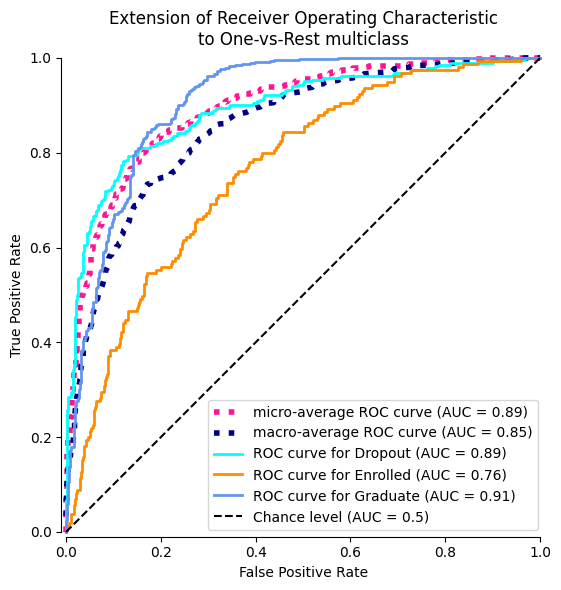

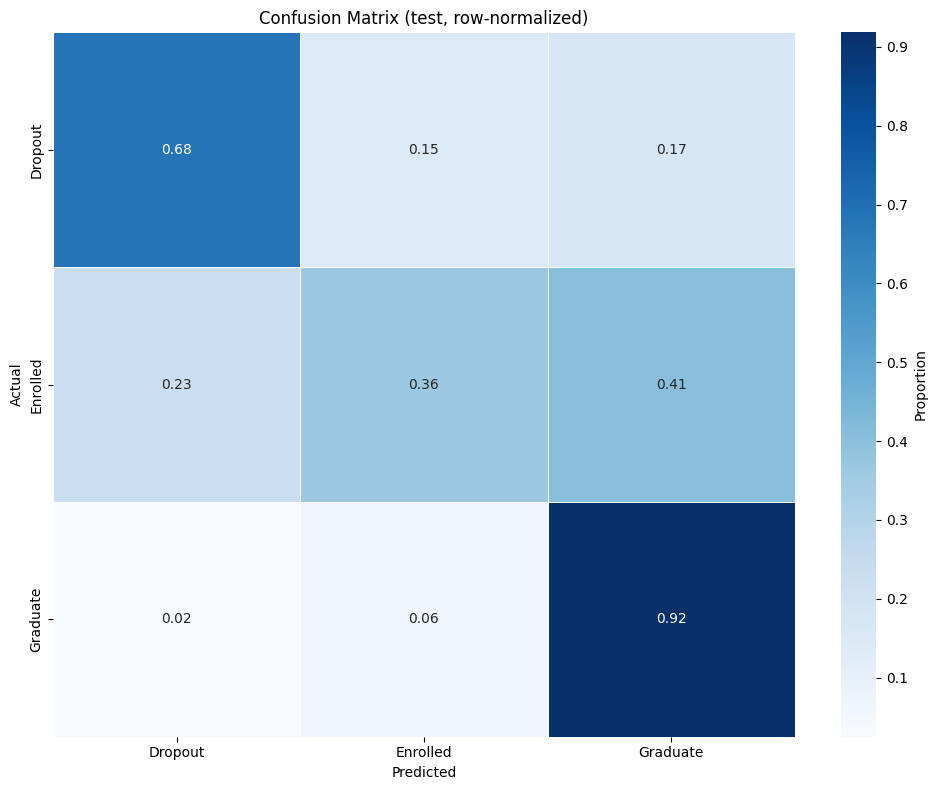

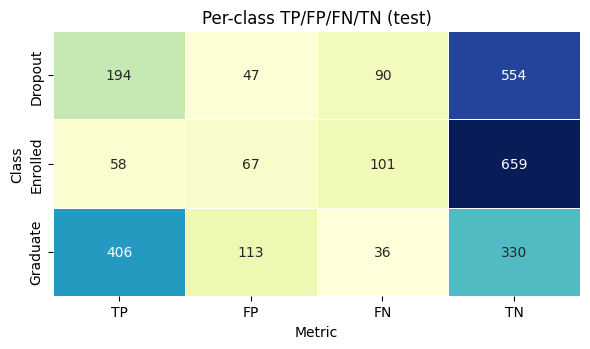

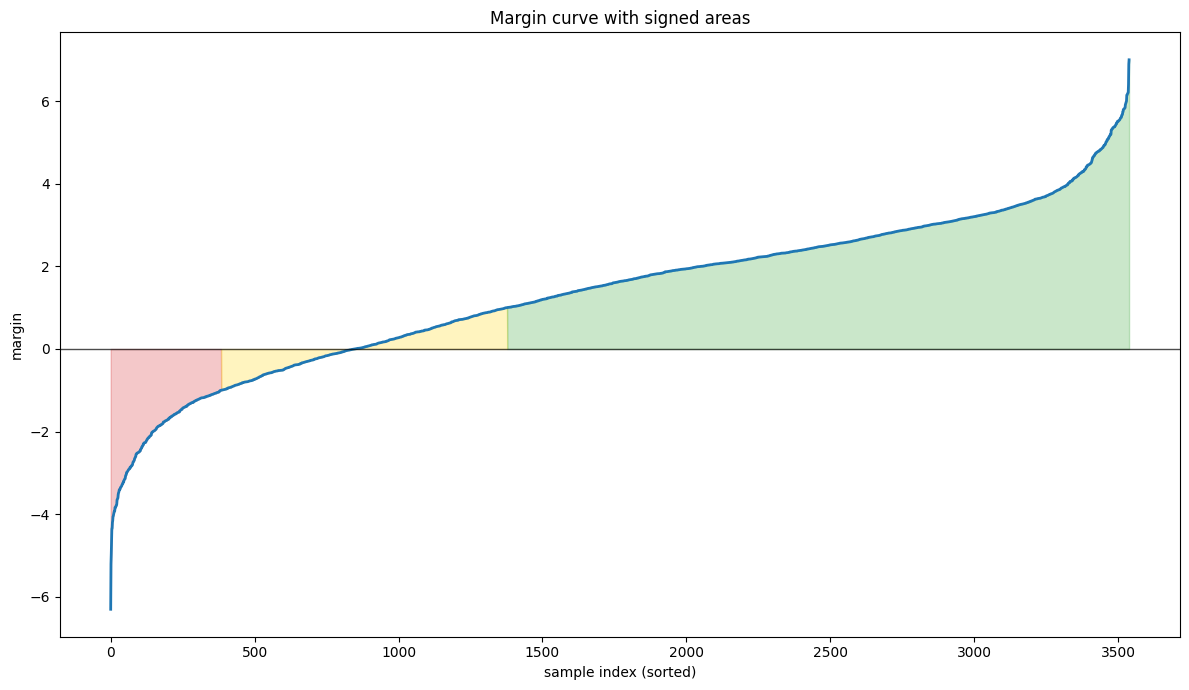

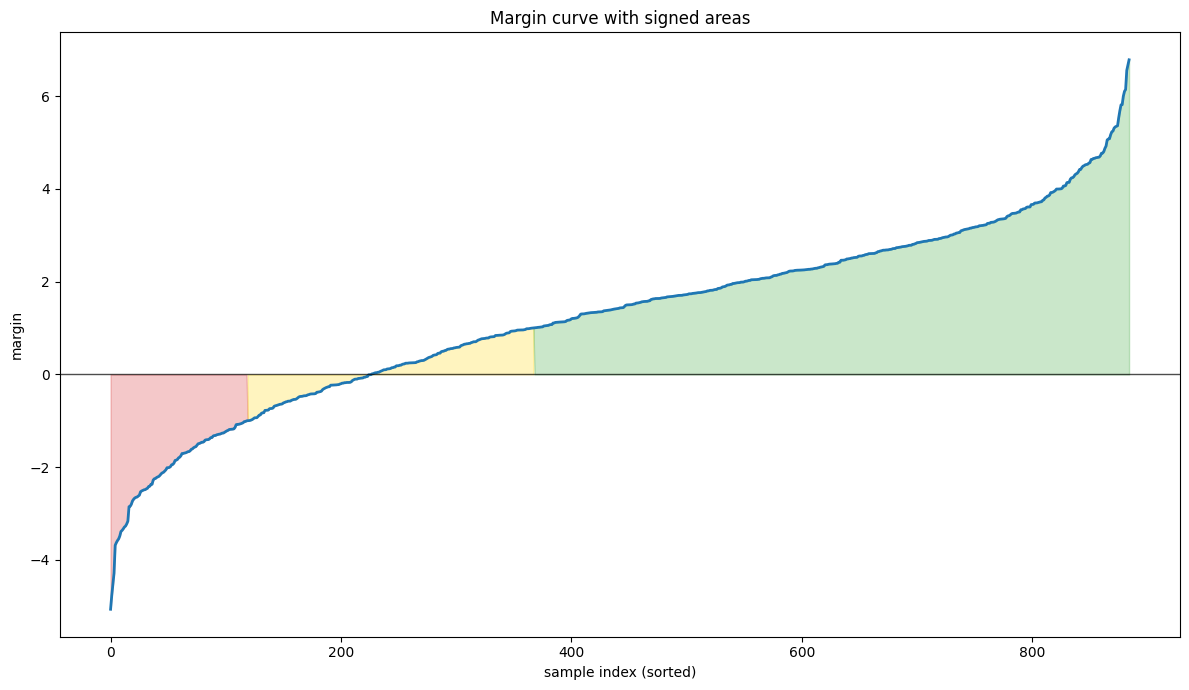

In [337]:
final_model, results = benchmark_classifier(
    LogRegNumpy,
    X_train_scaled, y_train_enc,
    X_test_scaled, y_test_enc,
    cv_folds=5,
    model_args=model_args,
    class_names=label_encoder.classes_,
    plot_roc=True,
    plot_confusions=True
)

---

In [385]:
class MarginMixin:
    def calc_margins(self, X: np.ndarray, y_true: np.ndarray):
        logits = self.decision_function(X)
        # gather true-class scores
        true_logits = logits[np.arange(X.shape[0]), y_true]
        # mask out the true class to get the best 'false' score per row
        logits[np.arange(logits.shape[0]), y_true] = -np.inf
        false_logits = logits.max(axis=1)
        margins = true_logits - false_logits
        return margins
    
def with_margins(BaseCls):
    bases = (BaseCls, MarginMixin) if issubclass(BaseCls, BaseEstimator) else (BaseCls, MarginMixin, BaseEstimator)
    name = f"{BaseCls.__name__}SK"
    cls = type(name, bases, {}) # metaclass?
    cls.__module__ = BaseCls.__module__
    cls.__doc__ = (BaseCls.__doc__ or "") + (
        "\n\nThis subclass adds `calc_margins(X, y_true)` to compute per-sample "
        "margins = score(true) - max_{c!=true} score(c)."
    )
    return cls

In [386]:
SGDClassifierSK = with_margins(SGDClassifier)
LogisticRegressionSK = with_margins(LogisticRegression)

In [387]:
sgd_logreg_sk = SGDClassifierSK(
    loss = 'log_loss',
    penalty='l2',
    alpha=0.0,
    max_iter=1000,
    tol=1e-4,
    shuffle=True,
    random_state=SEED,
    learning_rate='constant',
    eta0=1e-2,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=50,
    n_jobs=1,
    verbose=1
)

In [388]:
sgd_logreg_sk.fit(X_train_scaled, y_train_enc)

-- Epoch 1
Norm: 1.86, NNZs: 36, Bias: -0.935350, T: 3539, Avg. loss: 0.351668
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 2.16, NNZs: 36, Bias: -1.087949, T: 7078, Avg. loss: 0.317627
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 2.28, NNZs: 36, Bias: -1.089690, T: 10617, Avg. loss: 0.316961
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 2.45, NNZs: 36, Bias: -1.111035, T: 14156, Avg. loss: 0.314405
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2.50, NNZs: 36, Bias: -0.993476, T: 17695, Avg. loss: 0.314377
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 2.60, NNZs: 36, Bias: -0.992040, T: 21234, Avg. loss: 0.314221
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 2.63, NNZs: 36, Bias: -1.112318, T: 24773, Avg. loss: 0.313114
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 2.74, NNZs: 36, Bias: -1.114432, T: 28312, Avg. loss: 0.311679
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 2.71, NNZs: 36, Bias: -1.041426, T: 31851, Avg. loss: 0.313813
To

SGDClassifierSK(alpha=0.0, eta0=0.01, learning_rate='constant', loss='log_loss',
                n_iter_no_change=50, n_jobs=1, random_state=18092025,
                tol=0.0001, verbose=1)

In [389]:
preds_sk = sgd_logreg_sk.predict(X_test_scaled)

In [390]:
print(f'Test accuracy: {(preds_sk == y_test_enc).mean()*100.:.4f}')

Test accuracy: 74.8023


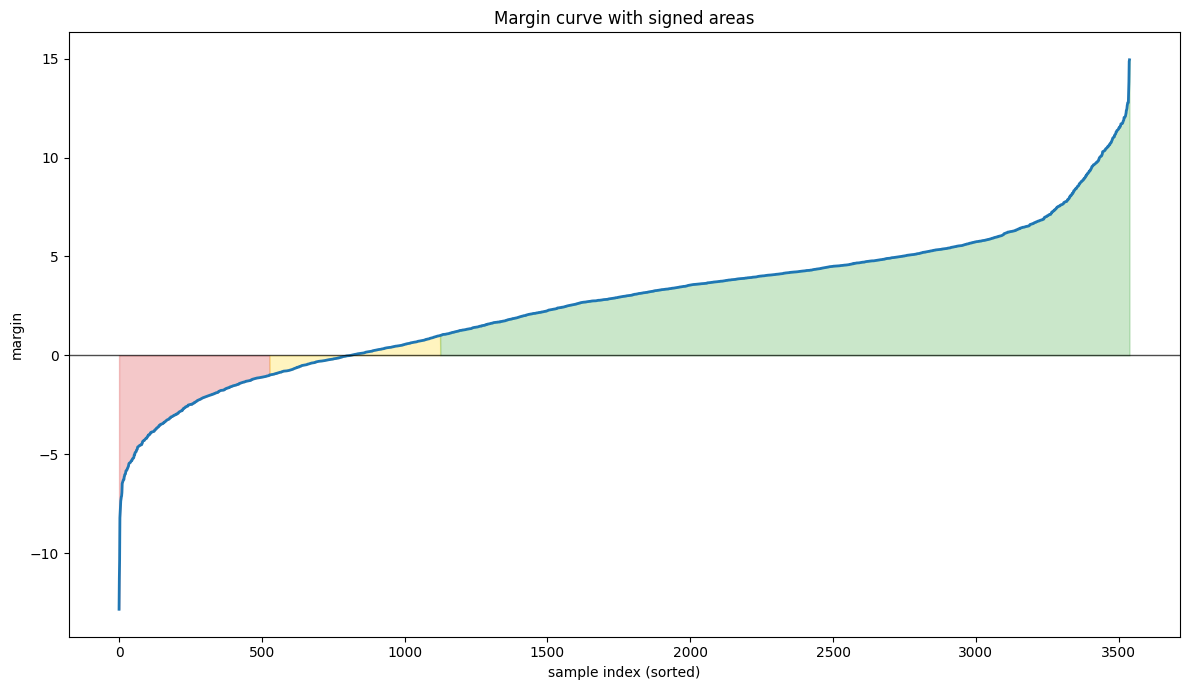

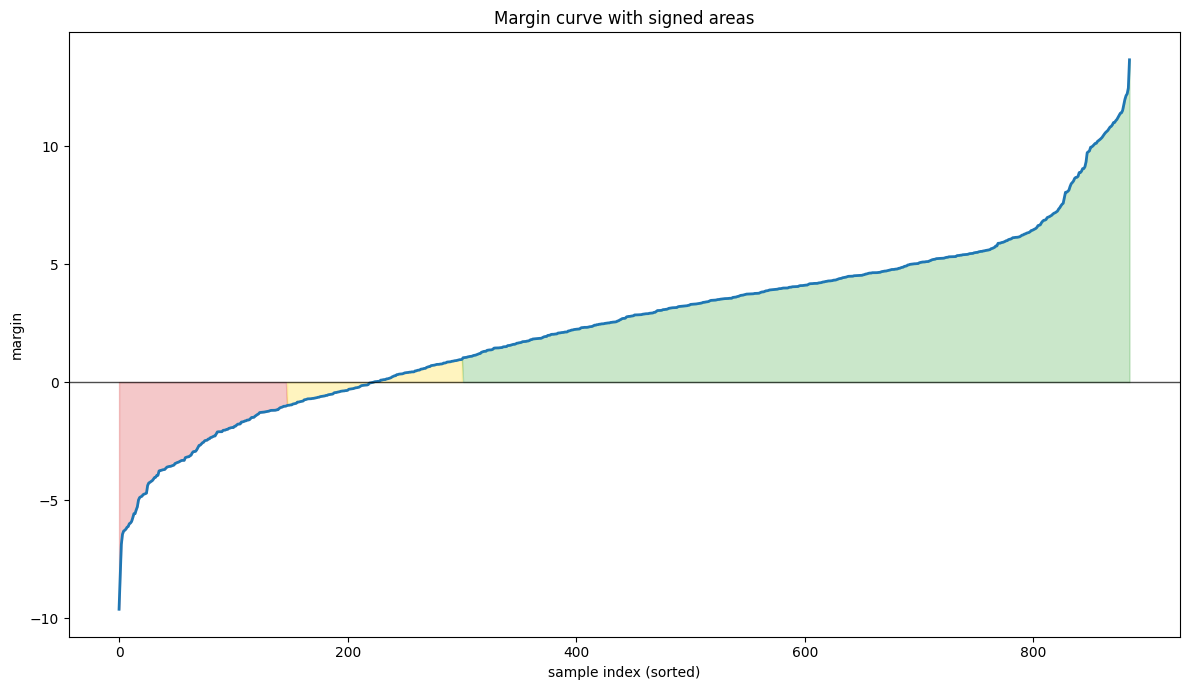

In [391]:
margins_train = sgd_logreg_sk.calc_margins(X_train_scaled, y_train_enc)
margins_test  = sgd_logreg_sk.calc_margins(X_test_scaled,  y_test_enc)

viz_margins(margins_train)
viz_margins(margins_test)

---

In [397]:
logreg_sk = LogisticRegressionSK(
    penalty=None, #'l2'
    C=1.0,
    max_iter=1000,
    tol=1e-4,
    random_state=SEED,
    solver='lbfgs',
    n_jobs=1,
    verbose=1
)

In [398]:
logreg_sk.fit(X_train_scaled, y_train_enc)

LogisticRegressionSK(max_iter=1000, n_jobs=1, penalty=None,
                     random_state=18092025, verbose=1)

In [399]:
preds_sk = logreg_sk.predict(X_test_scaled)

In [400]:
print(f'Test accuracy: {(preds_sk == y_test_enc).mean()*100.:.4f}')

Test accuracy: 74.5763


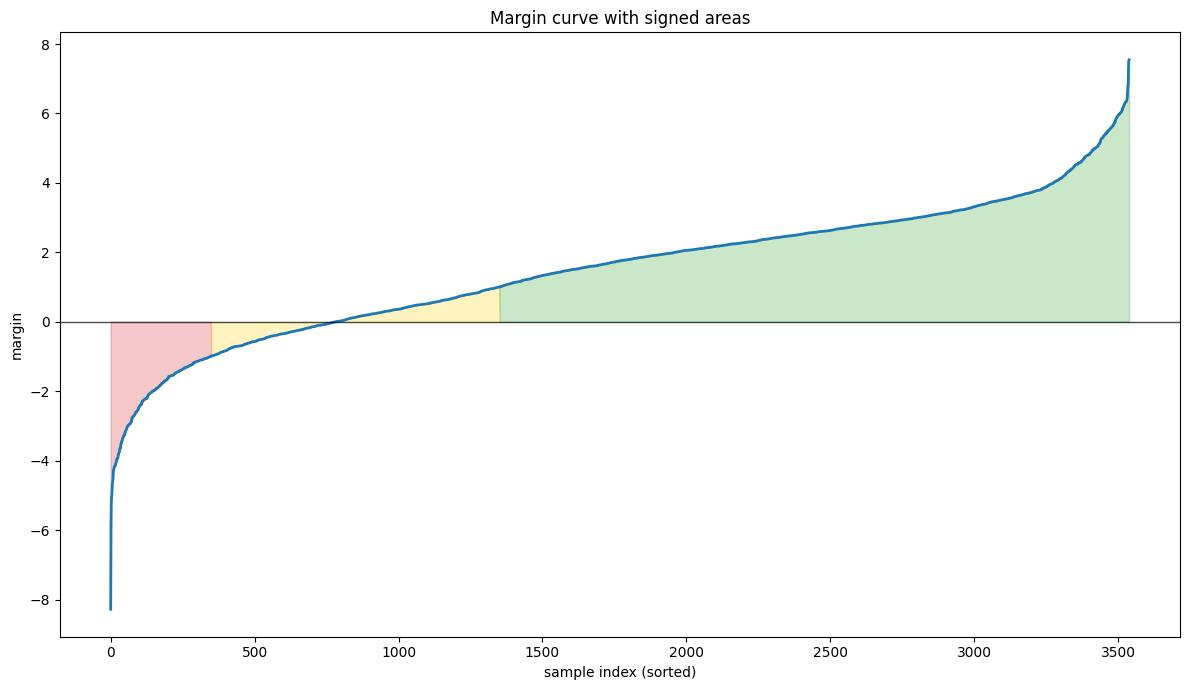

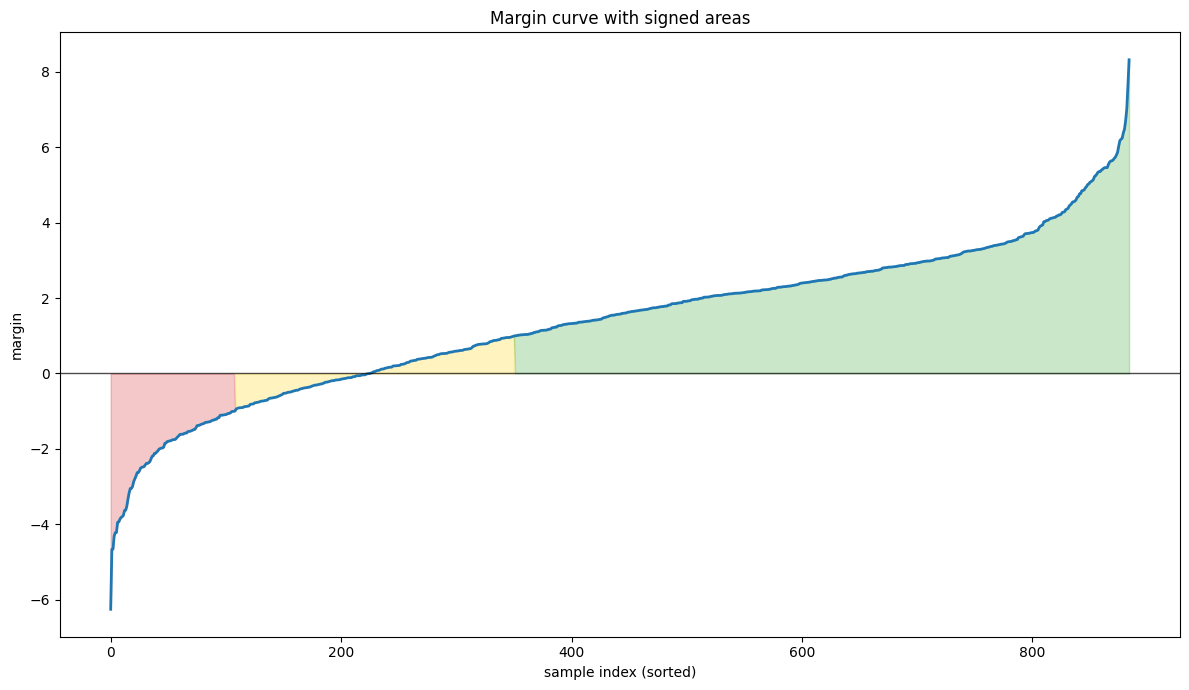

In [401]:
margins_train = logreg_sk.calc_margins(X_train_scaled, y_train_enc)
margins_test  = logreg_sk.calc_margins(X_test_scaled,  y_test_enc)

viz_margins(margins_train)
viz_margins(margins_test)